In [1]:
import os
import sys
import json

from typing import Any, List, Optional, Dict, Union


class _UniqueIdsController:
    def __init__(self):
        self._ids = set()
        self._last_id = -1

    def has(self, object_id: int) -> bool:
        return object_id in self._ids

    def get_new_id(self) -> int:
        self._last_id += 1
        return self._last_id

    def force_add_id(self, object_id: int) -> bool:
        if object_id in self._ids:
            return False
        else:
            self._last_id = max(self._last_id, object_id)
            self._ids.add(object_id)
            return True


class COCODetectionFactory:
    """
    # Create dataset
    dataset = COCODetectionFactory()

    # set info to dataset
    dataset.set_info(description='my_dataset', url='http://localhost.com',
                     version='0.0.1', year=2019, contributor='Avi2011class',
                     date_created='20.12.2019')

    # add interesting licenses
    dataset.add_licence(name='GPLv3', url='https://en.wikipedia.org/wiki/GPL_License')
    dataset.add_licence(name='MIT', url='https://en.wikipedia.org/wiki/MIT_License')

    # add categories of objects
    dataset.add_category(category_id=10, name='man', supercategory='person')  # with fixed id, 10 is returned
    dataset.add_category(name='woman', supercategory='person')  # with auto selected id, 11 is returned
    dataset.add_category(category_id=5, name='child', supercategory='person')  # with fixed id, 5 is returned
    # dataset.add_category(category_id=5, name='dog', supercategory='not person') will raises RuntimeError,
    # id=11 already exists

    # add images to dataset
    dataset.add_image(image_id=0, file_name='photo_01.jpg')  # with fixed id, 0 is returned
    dataset.add_image(file_name='photo_02.jpg')  # without fixed id, 1 is returned
    # dataset.add_image(image_id=1, file_name='photo_01.jpg') will raise RuntimeError, id is already exists

    # Adds annotations to dataset

    # add annotation to image with image_id=0 and category_id=0
    dataset.add_bbox(bbox_left=0, bbox_height=10, bbox_top=0, bbox_width=0, image_id=0, category_id=11)

    # add annotation to image with auto found image_id=1 and auto found category_id=10
    dataset.add_bbox(bbox_left=0, bbox_height=10, bbox_top=0, bbox_width=0,
                     image_file_name='photo_02.jpg', category_name='man')

    # add annotation to image with image_id=0 and category_id=102, category=102 may be created in future
    dataset.add_bbox(bbox_left=0, bbox_height=10, bbox_top=0, bbox_width=0, image_id=0, category_id=102)

    # raises RuntimeError because category_name doesn't exists
    # dataset.add_bbox(bbox_left=0, bbox_height=10, bbox_top=0, bbox_width=0, image_id=0, category_name='blabla')

    # save dataset to annotation file
    annotation_file_content = dataset.get_json()
    with open('annotation_file.json', 'w') as f:
        f.write(annotation_file_content)
    """

    def __init__(self):
        self._output = {
            "info": {},
            "licenses": [],
            "categories": [],
            "images": [],
            "annotations": []
        }
        self._licence_ids = _UniqueIdsController()
        self._image_ids = _UniqueIdsController()
        self._category_ids = _UniqueIdsController()
        self._annotation_ids = _UniqueIdsController()

        self._category_names_to_idx = {}
        self._image_names_to_idx = {}
        self._annotation_names_to_idx = {}

    def set_info(self,
                 description: str = "",
                 url: str = "",
                 version: str = "",
                 year: Union[str, int] = "",
                 contributor: str = "",
                 date_created: str = ""):
        """Set information in mscoco format
        Args:
            description (str): dataset description
            url (str): dataset url
            version (str): dataset version
            year (Union[str, int]): dataset year
            contributor (str): contribution info
            date_created (str): date

        Return:
            COCODetectionFactory: reference to current COCODetectionFactory object
        """

        self._output['info'] = {
            'description': description,
            'url': url,
            'version': version,
            'year': year,
            'contributor': contributor,
            'date_created': date_created
        }

        return self

    def add_licence(self,
                    licence_id: Optional[int] = None,
                    name: str = "",
                    url: str = "") -> Any:
        """Adds license to dataset, dataset may contain more then one license, it will be stored as list

        Args:
            licence_id (optional[int]): id of license, must be unique, if None random unique value will be used
            name (str): name of license
            url(str): url to license

        Returns:
            int: id of license
        """

        if licence_id is None:
            licence_id = self._licence_ids.get_new_id()
        elif self._licence_ids.has(licence_id):
            raise RuntimeError('License ids must be unique, but \"{}\" already exists'.format(licence_id))

        self._output['licenses'].append({
            'id': licence_id,
            'name': name,
            'url': url
        })
        return licence_id

    def add_category(self,
                     category_id: Optional[int] = None,
                     name: str = "",
                     supercategory: str = ""):
        """ Adds category to dataset

        Args:
            category_id (int): id of category, must be unique, if None random unique value will be used
            name (str): name of category, must be unique for dataset
            supercategory (str): name of supercategory
        Returns:
             int: id of category
        """
        if category_id is None:
            category_id = self._category_ids.get_new_id()
        elif self._category_ids.has(category_id):
            raise RuntimeError('Category ids must be unique, but \"{}\" already exists'.format(category_id))

        if name in self._image_names_to_idx:
            raise RuntimeError('Category names must be unique, but \"{}\" already exists'.format(name))
        self._category_names_to_idx[name] = category_id

        self._output['categories'].append({
            'id': category_id,
            'name': name,
            'supercategory': supercategory
        })
        return category_id

    def add_image(self,
                  image_id: Optional[int] = None,
                  file_name: str = "",
                  height: Optional[int] = None,
                  width: Optional[int] = None) -> Any:
        """ Adds image to dataset

        Args:
            image_id (Optional[int]): id of image, must be unique, if None random unique value will be used
            file_name (str): filename where image stored, must be unique for dataset
            height (Optional[int]): height of image
            width (optional[int]): width of image
        Returns:
            int: id of image
        """

        if image_id is None:
            image_id = self._image_ids.get_new_id()
        elif self._category_ids.has(image_id):
            raise RuntimeError('Image ids must be unique, but \"{}\" already exists'.format(category_id))

        if file_name in self._image_names_to_idx:
            raise RuntimeError('Image file names must be unique, but \"{}\" already exists'.format(name))
        self._image_names_to_idx[file_name] = image_id

        self._output['images'].append({
            'id': image_id,
            'file_name': file_name,
            'height': height if height is not None else -1,
            'width': width if width is not None else -1
        })

        return image_id
    
    def add_bbox(self,
                 bbox_left: int = 0,
                 bbox_top: int = 0,
                 bbox_width: int = 0,
                 bbox_height: int = 0,
                 image_id: Optional[int] = None,
                 image_file_name: Optional[str] = None,
                 category_id: Optional[int] = None,
                 category_name: Optional[str] = None,
                 iscrowd: bool = False):
        """Adds bounding box to image in dataset
        
        One of image_id and image_file_name must be specified. If both image_id will be used
        One of category_id and category_name must be specified. If both category_id will be used

        Args:
            bbox_left (int):
            bbox_top (int):
            bbox_width (int):
            bbox_height (int):
            image_id (Optional[int]): if None may be computed from image_file_name. Image_id may be unknown
            image_file_name (Optional[str]): None or name of file added to dataset
            category_id (Optional[int]): if None may be computed from category_name. Category_id may be unknown
            category_name (Optional[str]): None or name of category added to dataset
            iscrowd (bool):
        Returns:
            int: id of bbox
        """

        if image_id is None and image_file_name is None:
            raise RuntimeError("One of image_id and image_file_name must be specified")

        if image_id is None:
            if image_file_name in self._image_names_to_idx:
                image_id = self._image_names_to_idx[image_file_name]
            else:
                raise RuntimeError("Unknown image file name \"{}\"".format(image_file_name))

        if category_id is None and category_name is None:
            raise RuntimeError("One of category_id and category_name must be specified")

        if category_id is None:
            if category_name in self._category_names_to_idx:
                category_id = self._category_names_to_idx[category_name]
            else:
                raise RuntimeError("Unknown category name \"{}\"".format(category_name))

        new_id = self._annotation_ids.get_new_id()
        self._output['annotations'].append({
            'id': new_id,
            'image_id': image_id,
            'category_id': category_id,
            'segmentation': [],
            'area': 0,
            'bbox': [bbox_left, bbox_top, bbox_width, bbox_height],
            'iscrowd': iscrowd,
        })
        return new_id

    def get_dict(self) -> Dict[str, Any]:
        """
        Args:

        Returns:
            Dict[str, Any]: dict in mscoco format
        """
        return self._output

    def get_json(self, **kwargs) -> str:
        """
        Args:
            **kwargs: passed to json.dumps
        Returns:
            str: dataset in json format
        """
        return json.dumps(self._output, **kwargs)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [13]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

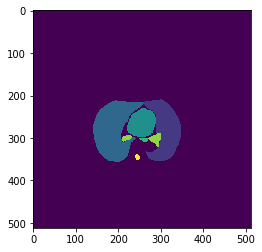

In [11]:
mask = np.load("../data/Thoracic_OAR_2d/1/mask.45.npy")
plt.imshow(mask)

In [15]:
np.unique(mask)

array([0., 1., 2., 3., 4., 5., 6.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


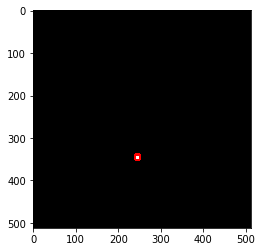

In [106]:
mask_plot = mask.copy()
mask_plot = (mask == 6).astype(np.float32)
ymin, ymax, xmin, xmax = bbox(mask_plot)
mask_plot = np.stack((mask_plot, mask_plot, mask_plot), axis=-1)
mask_plot = cv2.rectangle(mask_plot * 255, (xmin, ymin), (xmax, ymax), (255, 0, 0), 4)
plt.imshow(mask_plot)